# Ejercicio 2¶

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

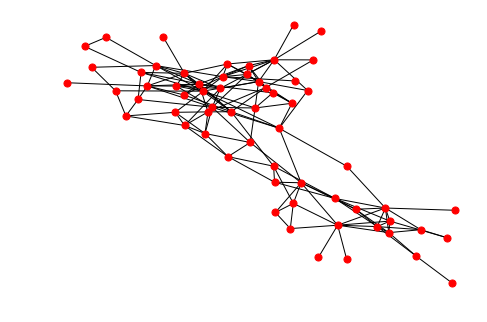

In [4]:
G=nx.read_gml('dolphins.gml')
nx.draw(G, with_labels=False, font_weight='bold',node_size=50)
plt.show()
#list(G)

In [5]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

data_gender=ldata('dolphinsGender.txt')

data_gender
colores=[]

#le agregamos el atributo "genero" al grafo G
for elemento in data_gender:
    G.node[elemento[0]]['genero']=elemento[1]
    
#creamos un vector de colores que vincula los generos (mismo orden)     
for gen in nx.get_node_attributes(G, "genero").values():
    if gen=='f':
        colores.append('red')
    elif gen=='m':
        colores.append('blue')
    else:
        colores.append('grey')
        


In [6]:
#verificamos el vector colores
nx.get_node_attributes(G, "genero").values()

### TAREA: buscar como acceder a las propiedades de un nodo

['m',
 'm',
 'm',
 'm',
 'm',
 'f',
 'm',
 'm',
 'm',
 'f',
 'm',
 'm',
 'f',
 'm',
 'm',
 'f',
 'm',
 'f',
 'm',
 'm',
 'm',
 'm',
 'f',
 'm',
 'f',
 'f',
 'f',
 'm',
 'f',
 'm',
 'f',
 'm',
 'NA',
 'f',
 'f',
 'm',
 'm',
 'f',
 'f',
 'f',
 'NA',
 'm',
 'f',
 'NA',
 'm',
 'f',
 'm',
 'm',
 'f',
 'f',
 'm',
 'm',
 'f',
 'f',
 'm',
 'm',
 'm',
 'm',
 'f',
 'f',
 'NA',
 'm']

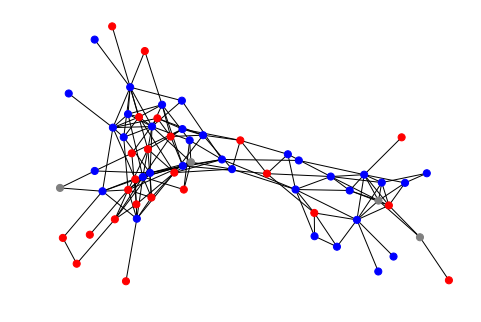

In [9]:
nx.draw(G, with_labels=False,node_color=colores, font_weight='bold',node_size=50)
plt.show()

In [10]:
G.node['Ripplefluke']

{'genero': 'NA'}